In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
%matplotlib inline
start_time = dt.datetime.now()

In [2]:
# set some parameters
num_files = 1
# num_filter to be about 10 to 20% of the original # variables
num_filter = 300
num_wrapper = 30
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [3]:
%%time
filter_score_df_list = []
for i in range(num_files):
#     file_name = "vars"+str(i+1)+'.csv'
    file_name = 'vars.csv'
    df = pd.read_csv(file_name)
    print("********** working on",file_name,"size is",df.shape)
    df = df.set_index(index_name) 
    df.drop(columns = ['U*_cardnum', 'U*_merchnum'], inplace=True) # drop Benford's law variables
#     df = df[df.index <= 84298] # remove the last two months as the out-of-time data (OOT)
    df = df[df.index >= 3345] # remove the first 2 weeks of records since their variables aren't well formed
    df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
    goods = df[df[y_name] == good_label]
    bads = df[df[y_name] == bad_label]
    del df # don't need this file anymore
    num_goods = len(goods)
    num_bads = len(bads)
    num_vars = len(bads.columns)-2
    if(balance != 0):
        if(i == 0):
            num_goods_desired = int(min(num_goods,num_bads*balance))
            goods = goods.sample(n=num_goods_desired,random_state=1)
            goods_keep = list(goods.index)
            goods_keep.sort()
    
        if(i > 0):
            goods = goods.loc[goods_keep] 
            
    df_sampled = pd.concat([goods,bads])
    df_sampled.sort_index(inplace=True)
    filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
    filter_score.columns = ['variable','filter score']   
    j = 0
    for column in df_sampled:
        filter_score.loc[j,'variable'] = column
        filter_score.loc[j,'filter score'] = sps.ks_2samp(goods[column],bads[column])[0]
        j = j+1
        if j%100 == 0:
            print(j)

    filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
    vars_keep = list(filter_score['variable'][1:num_filter+1]) 
    print(file_name,filter_score.head(20))
    if(i == 0): # if first time through need to initialize some stuff
        Y = pd.DataFrame(df_sampled[y_name], index=df_sampled.index)
        df_top = df_sampled.filter(vars_keep, axis=1)
            
    if(i > 0): # if more than one variable file we use this loop
        data_new_top = df_sampled.filter(vars_keep, axis=1)
        df_top = pd.concat([df_top,data_new_top], axis=1)

    filter_score_df_list.append(filter_score)
    
    del goods # delete these before starting the next file, if any
    del bads
    gc.collect()
filter_score = pd.concat(filter_score_df_list)

********** working on vars.csv size is (96397, 1193)
100
200
300
400
500
600
700
800
900
1000
1100
vars.csv                        variable  filter score
0                         Fraud      1.000000
364           card_zip3_total_7      0.676693
199            card_zip_total_7      0.666978
355           card_zip3_total_3      0.660487
373          card_zip3_total_14      0.659383
190            card_zip_total_3      0.652443
208           card_zip_total_14      0.652365
144          card_merch_total_7      0.637920
217           card_zip_total_30      0.637148
362             card_zip3_max_7      0.631058
135          card_merch_total_3      0.631024
153         card_merch_total_14      0.630240
382          card_zip3_total_30      0.630156
371            card_zip3_max_14      0.629632
206             card_zip_max_14      0.628050
197              card_zip_max_7      0.625236
215             card_zip_max_30      0.624214
419      Card_Merchdesc_total_7      0.621990
529  Card_Merchnum

In [4]:
filter_score.sort_values(by=['filter score'], ascending=False, inplace=True)
filter_score.reset_index(drop=True,inplace=True)

In [5]:
filter_score.head(30)

,variable,filter score
0,Fraud,1.000000
1,card_zip3_total_7,0.676693
2,card_zip_total_7,0.666978
3,card_zip3_total_3,0.660487
4,card_zip3_total_14,0.659383
5,card_zip_total_3,0.652443
6,card_zip_total_14,0.652365
7,card_merch_total_7,0.637920
8,card_zip_total_30,0.637148
9,card_zip3_max_7,0.631058


In [6]:
filter_score.tail(10)

,variable,filter score
1181,card_merch_unique_count_for_zip3_7,0.000946
1182,Card_Merchdesc_unique_count_for_zip3_3,0.000891
1183,card_merch_unique_count_for_zip3_3,0.000815
1184,Card_Merchnum_desc_unique_count_for_zip3_7,0.000793
1185,Card_Merchdesc_unique_count_for_zip3_1,0.000706
1186,card_merch_unique_count_for_zip3_1,0.000685
1187,Card_Merchnum_desc_unique_count_for_zip3_3,0.000663
1188,Merchnum_desc_unique_count_for_zip3_3,0.000644
1189,Card_Merchnum_desc_unique_count_for_zip3_1,0.000576
1190,card_merch_unique_count_for_Cardnum_1,0.000000


In [7]:
filter_score.shape

(1191, 2)

In [8]:
filter_score.head(80).to_csv('filter_top.csv')
vars_keep = list(filter_score['variable'][num_files:num_filter+3])
print(i,' vars_keep:',vars_keep)

0  vars_keep: ['card_zip3_total_7', 'card_zip_total_7', 'card_zip3_total_3', 'card_zip3_total_14', 'card_zip_total_3', 'card_zip_total_14', 'card_merch_total_7', 'card_zip_total_30', 'card_zip3_max_7', 'card_merch_total_3', 'card_merch_total_14', 'card_zip3_total_30', 'card_zip3_max_14', 'card_zip_max_14', 'card_zip_max_7', 'card_zip_max_30', 'Card_Merchdesc_total_7', 'Card_Merchnum_desc_total_7', 'card_zip3_total_1', 'card_merch_total_30', 'card_zip3_max_30', 'Card_Merchdesc_total_14', 'Card_Merchnum_desc_total_14', 'card_zip_total_1', 'Card_Merchdesc_total_3', 'Card_Merchnum_desc_total_3', 'Card_Merchdesc_total_30', 'card_zip3_max_3', 'Card_Merchnum_desc_total_30', 'card_merch_max_14', 'card_merch_max_30', 'Card_Merchdesc_max_14', 'card_merch_max_7', 'Card_Merchnum_desc_max_14', 'Card_Merchdesc_max_30', 'Card_Merchdesc_max_7', 'Card_Merchnum_desc_max_30', 'card_zip_max_3', 'Card_Merchnum_desc_max_7', 'card_merch_total_1', 'card_merch_max_3', 'Card_Merchdesc_max_3', 'card_zip3_max_1',

In [9]:
vars_keep_df = pd.DataFrame({'col':vars_keep})
vars_keep_df.to_csv('vars_keep_filter.csv',index=False)
df_keep = df_top.filter(vars_keep, axis=1)
df_keep.head()

,card_zip3_total_7,card_zip_total_7,card_zip3_total_3,card_zip3_total_14,card_zip_total_3,card_zip_total_14,card_merch_total_7,card_zip_total_30,card_zip3_max_7,card_merch_total_3,...,Merchnum_actual/avg_30,merch_zip_actual/avg_30,card_zip_actual/toal_3,card_zip_day_since,Cardnum_variability_max_1,Merchnum_variability_med_7,merch_zip_variability_med_7,Merchnum_desc_variability_avg_30,card_zip_actual/toal_1,card_merch_count_7
Recnum,,,,,,,,,,,,,,,,,,,,,
3345,1960.27,1960.27,333.47,1960.27,333.47,1960.27,1960.27,1960.27,983.66,333.47,...,0.720066,0.720066,1.000000,4.0,596.94,-35.030,-35.030,129.640333,1.000000,3
3346,341.23,341.23,178.41,530.02,178.41,530.02,324.43,530.02,15.40,165.41,...,0.793762,0.793762,0.024494,2.0,652.13,-0.630,-0.630,0.000000,1.000000,69
3347,582.94,582.94,582.94,2306.98,582.94,2306.98,582.94,2306.98,278.73,582.94,...,1.139066,1.139066,0.466480,1.0,1108.52,0.000,0.000,-33.199231,0.466480,3
3348,344.85,344.85,182.03,533.64,182.03,533.64,328.05,533.64,15.40,169.03,...,0.658272,0.658272,0.019887,0.0,652.88,0.085,0.085,0.375000,0.453066,70
3349,16.28,16.28,16.28,16.28,16.28,16.28,16.28,16.28,16.28,16.28,...,0.077556,0.077556,1.000000,14.0,0.00,97.590,97.590,193.632000,1.000000,1


In [10]:
df_keep.shape

(93059, 300)

In [11]:
Y.head()

,Fraud
Recnum,
3345,0
3346,0
3347,0
3348,0
3349,0


In [12]:
Y = Y.values
Y_save = Y.copy()

In [13]:
# Y = np.array(Y)
X = df_keep
print(Y)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [14]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:00:20.448686


In [15]:
print(X.shape,Y.shape)

(93059, 300) (93059, 1)


In [16]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [18]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

## Run a wrapper on the remaining top variables

In [19]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# If doing forward selection it's enough to stop at num_wrapper variables. 
# If doing backward selection you need to go through all the variables to get a sorted list of num_wrapper variables.

nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
# clf = LGBMClassifier(n_estimators=20,num_leaves=4) # simple, fast nonlinear model for the wrapper
# clf = MLPClassifier(hidden_layer_sizes=(5)) # neural net
clf = CatBoostClassifier(verbose=0, max_depth=4, iterations=20) # catboost
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=0,scoring=fdr,cv=4,n_jobs=-1) # use for forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=0,scoring=fdr,cv=4,n_jobs=-1) # use for backward selection
sfs.fit(X,Y)

CPU times: total: 48.1 s
Wall time: 38min 7s


SequentialFeatureSelector(cv=4,
                          estimator=<catboost.core.CatBoostClassifier object at 0x000001FD8C2E6520>,
                          k_features=(30, 30), n_jobs=-1,
                          scoring=<function fdr at 0x000001FD941B23A0>)

In [20]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 0:38:28.064067


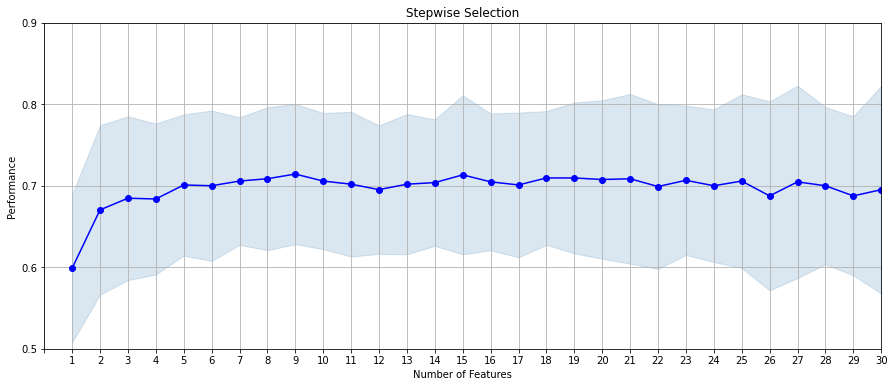

In [21]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=1))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0.5, 0.9])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('performance_nvars.png')
plt.show()

In [22]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [23]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(ordered_vars_FS.loc[i+1,'feature_names'])[0])
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = (list(set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])))
# might also need this following line. It converts a list to a string
        ordered_vars_FS.loc[i+1,'variable name'] = ordered_vars_FS.loc[i+1,'variable name'][0]

In [24]:
ordered_vars_FS

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err,add variables in this order,variable name
1,"(5,)","[0.6603053435114504, 0.5648854961832062, 0.702...",0.598728,"(card_zip_total_14,)",0.145379,0.090693,0.052361,1.0,card_zip_total_14
2,"(5, 20)","[0.7404580152671756, 0.6297709923664122, 0.790...",0.670345,"(card_zip_total_14, card_zip3_max_30)",0.166548,0.103899,0.059986,2.0,card_zip3_max_30
3,"(4, 5, 20)","[0.7709923664122137, 0.6641221374045801, 0.774...",0.684665,"(card_zip_total_3, card_zip_total_14, card_zip...",0.160927,0.100392,0.057961,3.0,card_zip_total_3
4,"(4, 5, 20, 130)","[0.7175572519083969, 0.6526717557251909, 0.809...",0.683736,"(card_zip_total_3, card_zip_total_14, card_zip...",0.148374,0.092561,0.05344,4.0,Merchnum_desc_total_0
5,"(4, 5, 20, 130, 229)","[0.7442748091603053, 0.683206106870229, 0.8053...",0.700926,"(card_zip_total_3, card_zip_total_14, card_zip...",0.13884,0.086614,0.050006,5.0,zip3_max_3
6,"(4, 5, 20, 47, 130, 229)","[0.7786259541984732, 0.6679389312977099, 0.790...",0.699965,"(card_zip_total_3, card_zip_total_14, card_zip...",0.147859,0.09224,0.053255,6.0,Card_Merchnum_desc_total_1
7,"(4, 5, 20, 47, 130, 205, 229)","[0.7519083969465649, 0.683206106870229, 0.7977...",0.705716,"(card_zip_total_3, card_zip_total_14, card_zip...",0.125414,0.078238,0.045171,7.0,zip3_total_1
8,"(4, 5, 20, 47, 92, 130, 205, 229)","[0.7633587786259542, 0.6641221374045801, 0.816...",0.708578,"(card_zip_total_3, card_zip_total_14, card_zip...",0.140523,0.087664,0.050613,8.0,Cardnum_total_0
9,"(4, 5, 20, 27, 47, 92, 130, 205, 229)","[0.8053435114503816, 0.6870229007633588, 0.778...",0.7143,"(card_zip_total_3, card_zip_total_14, card_zip...",0.137844,0.085992,0.049648,9.0,card_zip3_max_3
10,"(4, 5, 6, 20, 27, 47, 92, 130, 205, 229)","[0.7824427480916031, 0.6755725190839694, 0.782...",0.705708,"(card_zip_total_3, card_zip_total_14, card_mer...",0.133865,0.08351,0.048214,10.0,card_merch_total_7


In [25]:
ordered_vars_FS.to_csv('Wrapper_selection_info.csv', index=False)

In [26]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)
vars_keep

1                    card_zip_total_14
2                     card_zip3_max_30
3                     card_zip_total_3
4                Merchnum_desc_total_0
5                           zip3_max_3
6           Card_Merchnum_desc_total_1
7                         zip3_total_1
8                      Cardnum_total_0
9                      card_zip3_max_3
10                  card_merch_total_7
11           Card_Merchnum_desc_max_14
12    Merchnum_desc_variability_med_30
13                  card_zip3_total_14
14         Card_Merchnum_desc_total_14
15               Card_Merchdesc_max_30
16                  zip3_actual/max_14
17                    card_merch_med_3
18                Card_Merchdesc_med_3
19               Merchnum_desc_total_1
20             merch_zip_actual/avg_30
21                          zip3_avg_3
22                   card_zip3_count_3
23         card_zip3_variability_max_7
24                     merch_zip_avg_3
25              Card_Merchdesc_total_3
26                      M

In [27]:
filter_score.set_index('variable',drop=True,inplace=True)
filter_score = filter_score.iloc[1:,:]
filter_score

,filter score
variable,
card_zip3_total_7,0.676693
card_zip_total_7,0.666978
card_zip3_total_3,0.660487
card_zip3_total_14,0.659383
card_zip_total_3,0.652443
...,...
card_merch_unique_count_for_zip3_1,0.000685
Card_Merchnum_desc_unique_count_for_zip3_3,0.000663
Merchnum_desc_unique_count_for_zip3_3,0.000644


In [28]:
vars_keep_sorted = pd.DataFrame(vars_keep_list)
vars_keep_sorted.columns=['variable']
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

""
variable
card_zip_total_14
card_zip3_max_30
card_zip_total_3
Merchnum_desc_total_0
zip3_max_3


In [29]:
# TypeError: unhashable type: 'list' workaround
filterscore = filter_score.reset_index(level = 0)
filterscore.head()

,variable,filter score
0,card_zip3_total_7,0.676693
1,card_zip_total_7,0.666978
2,card_zip3_total_3,0.660487
3,card_zip3_total_14,0.659383
4,card_zip_total_3,0.652443


In [30]:
# issue probably is some values are lists i.e. [max_count_by_ssn_dob_7]
varskeepsorted = vars_keep_sorted.reset_index(level = 0)
varskeepsorted.head()

,variable
0,card_zip_total_14
1,card_zip3_max_30
2,card_zip_total_3
3,Merchnum_desc_total_0
4,zip3_max_3


In [31]:
varskeepsorted['variable'] = varskeepsorted['variable'].map(str)
varskeepsorted['variable'] = varskeepsorted['variable'].str.strip('[]')
varskeepsorted['variable'] = varskeepsorted['variable'].str.strip("''")

varskeepsorted.head()

,variable
0,card_zip_total_14
1,card_zip3_max_30
2,card_zip_total_3
3,Merchnum_desc_total_0
4,zip3_max_3


In [32]:
# vars_keep_sorted = pd.concat([varskeepsorted,filterscore],axis=1,join='inner')
vars_keep_sorted = varskeepsorted.merge(filter_score, how = 'inner', on = ['variable'])

In [33]:
vars_keep_sorted.set_index('variable',drop=True,inplace=True)
vars_keep_sorted.head()

,filter score
variable,
card_zip_total_14,0.652365
card_zip3_max_30,0.614516
card_zip_total_3,0.652443
Merchnum_desc_total_0,0.505209
zip3_max_3,0.394142


In [34]:
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted.reset_index(inplace=True)
vars_keep_sorted['index'] = vars_keep_sorted['index'] + 1
vars_keep_sorted.rename(columns={'index':'wrapper order'},inplace=True)
vars_keep_sorted.to_csv('vars_keep_sorted.csv',index=False)
vars_keep_sorted

,wrapper order,variable,filter score
0,1,card_zip_total_14,0.652365
1,2,card_zip3_max_30,0.614516
2,3,card_zip_total_3,0.652443
3,4,Merchnum_desc_total_0,0.505209
4,5,zip3_max_3,0.394142
5,6,Card_Merchnum_desc_total_1,0.573611
6,7,zip3_total_1,0.432200
7,8,Cardnum_total_0,0.523610
8,9,card_zip3_max_3,0.606675
9,10,card_merch_total_7,0.637920


In [35]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['card_zip_total_14',
 'card_zip3_max_30',
 'card_zip_total_3',
 'Merchnum_desc_total_0',
 'zip3_max_3',
 'Card_Merchnum_desc_total_1',
 'zip3_total_1',
 'Cardnum_total_0',
 'card_zip3_max_3',
 'card_merch_total_7',
 'Card_Merchnum_desc_max_14',
 'Merchnum_desc_variability_med_30',
 'card_zip3_total_14',
 'Card_Merchnum_desc_total_14',
 'Card_Merchdesc_max_30',
 'zip3_actual/max_14',
 'card_merch_med_3',
 'Card_Merchdesc_med_3',
 'Merchnum_desc_total_1',
 'merch_zip_actual/avg_30',
 'zip3_avg_3',
 'card_zip3_count_3',
 'card_zip3_variability_max_7',
 'merch_zip_avg_3',
 'Card_Merchdesc_total_3',
 'Merchnum_avg_1',
 'card_zip3_max_14',
 'merch_zip_max_1',
 'card_merch_variability_max_3',
 'card_merch_total_3',
 'Recnum',
 'Fraud']

In [36]:
filter_score

,filter score
variable,
card_zip3_total_7,0.676693
card_zip_total_7,0.666978
card_zip3_total_3,0.660487
card_zip3_total_14,0.659383
card_zip_total_3,0.652443
...,...
card_merch_unique_count_for_zip3_1,0.000685
Card_Merchnum_desc_unique_count_for_zip3_3,0.000663
Merchnum_desc_unique_count_for_zip3_3,0.000644


In [37]:
%%time
df = pd.read_csv(file_name)
df.shape

CPU times: total: 8.62 s
Wall time: 8.62 s


(96397, 1193)

In [41]:
df_keep = df.filter(vars_keep_list, axis=1)
# df_keep = df[df.index.isin(vars_keep_list)]
print(df_keep.shape)

(96397, 32)


In [42]:
df_keep.to_csv('vars_final.csv',index=False)

In [43]:
print("duration: ", dt.datetime.now() - start_time)

duration:  2:22:07.703552
